<a href="https://colab.research.google.com/github/akkk22/Codsoft/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Name: Akansha Shrivastava***

***Topic: Credit Card Fraud Detection***

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/creditcard.csv.zip', 'r') as f:
  f.extractall(path='/content/')

# Import Libraries

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="whitegrid")
import random
import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils import shuffle
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
LABELS = ["Normal", "Fraud"]
import plotly
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### ***DATA EXPLORATION***

In [22]:
df = pd.read_csv('/content/creditcard.csv', low_memory=False)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
frauds = df.loc[df['Class'] == 1]
non_frauds = df.loc[df['Class'] == 0]
print('Frauds ', len(frauds), ' transactions or ', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('No Fraud ', len(non_frauds), ' transactions or ', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

Frauds  492  transactions or  99.83 % of the dataset
No Fraud  284315  transactions or  0.17 % of the dataset


In [24]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [25]:
df.isnull().sum().max() #looking for null values

0

***No Null Values***

---



### ***VISUALIZING THE DATA***

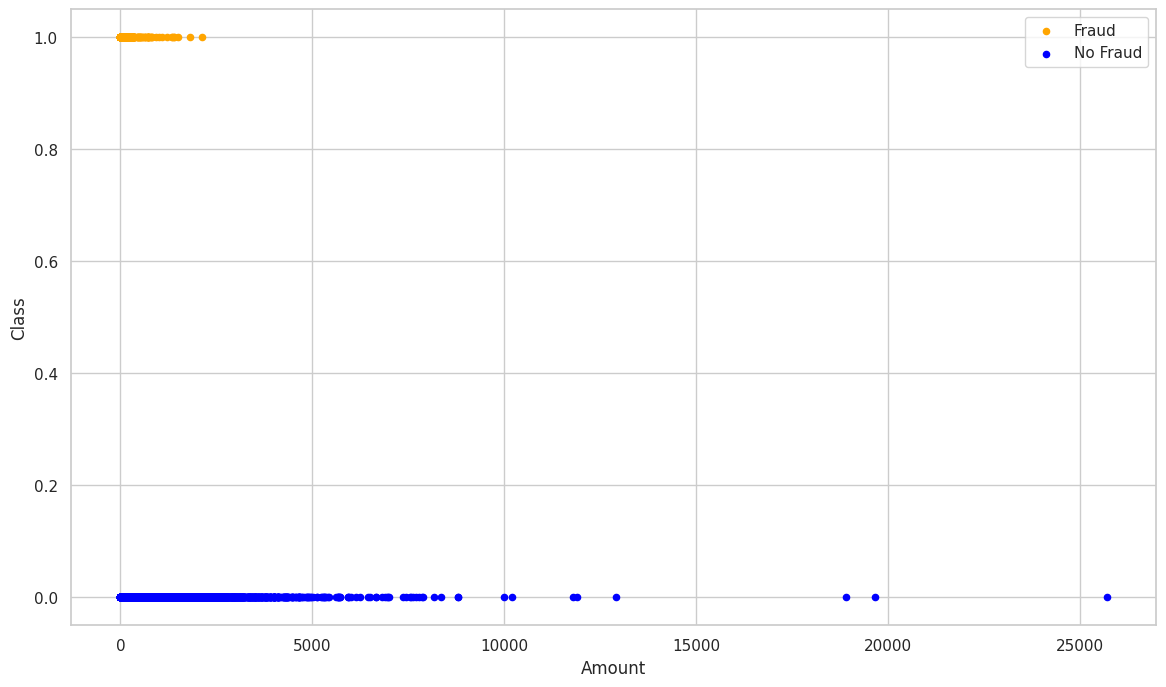

In [26]:
ax = frauds.plot.scatter(x='Amount', y='Class', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='Amount', y='Class', color='Blue', label='No Fraud', ax=ax)
plt.show()

### ***VISUALIZE WITH SEABORN***

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

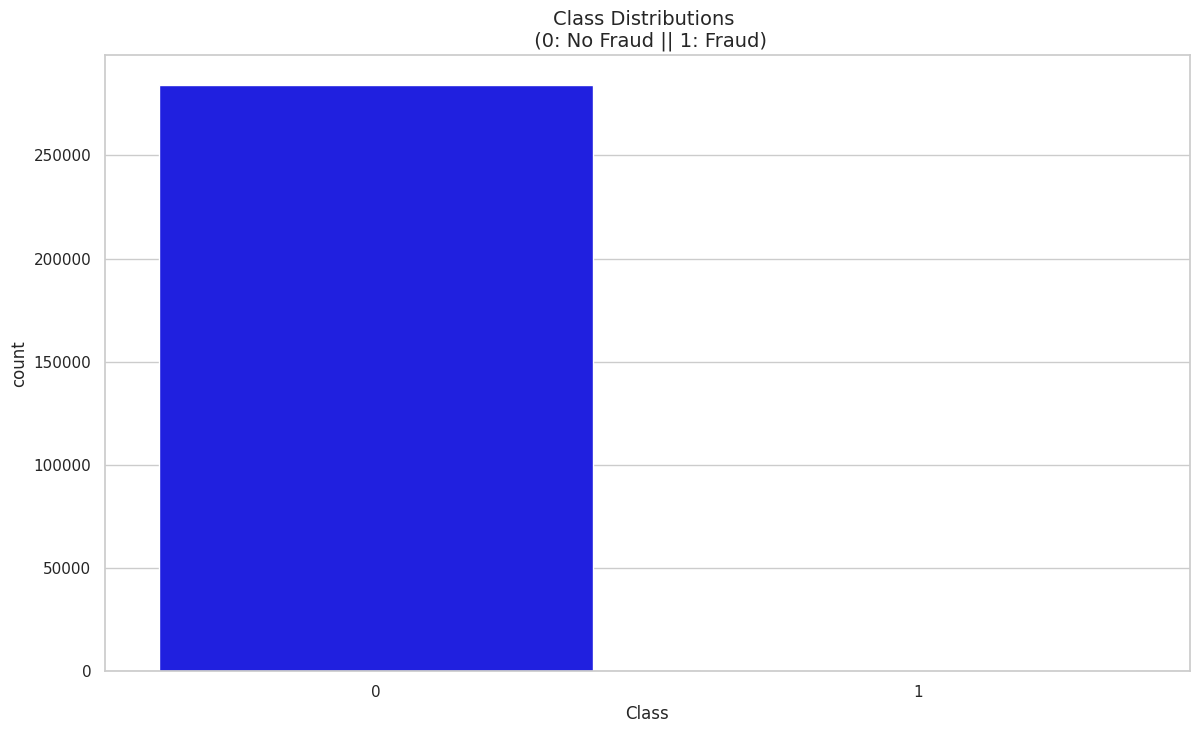

In [27]:
colors = ['Blue', 'Orange']

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

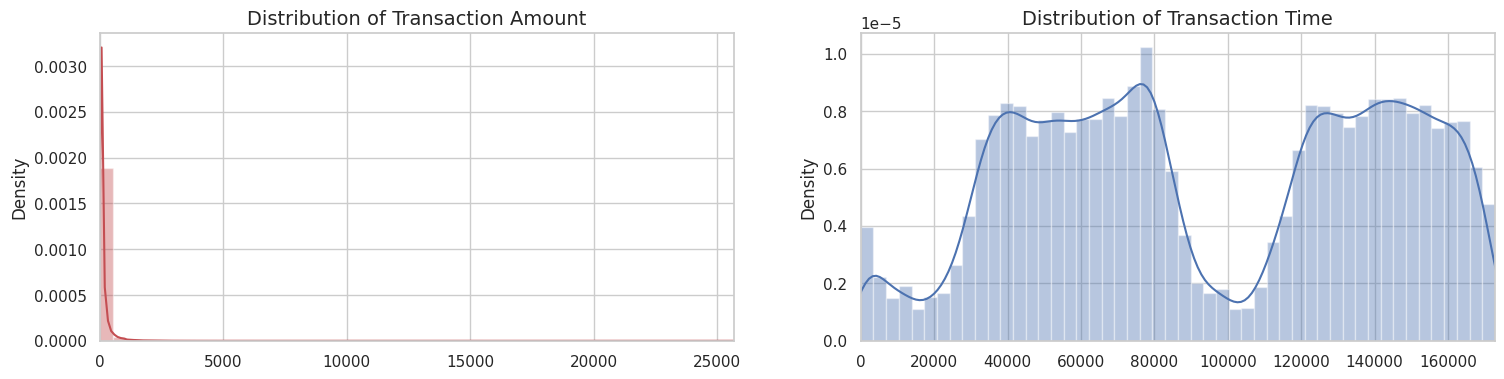

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### ***SCALING AND DISTRIBUTION***

Scaling: We will be scaling the columns Time and Amount.

Distributing: We will create a subsample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases. This will help our algorithm better understand patterns that determines whether a transaction is a fraud or not.

In [29]:
from sklearn.preprocessing import StandardScaler, RobustScaler



std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [30]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)



df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### ***SPLITTING UP THE GIVEN DATA***

In [31]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
  print("Train:", train_index, "Test:", test_index)
  original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
  original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_y_train = original_y_train.values
original_y_test = original_y_test.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_y_train))
print(test_counts_label/ len(original_y_test))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


### ***RANDOM UNDERSAMPLE AND OVERSAMPLING***

In [32]:
df = df.sample(frac=1)

# amount of fraud classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
148863,1.300915,0.065473,1.652586,-0.752044,-0.616038,0.721161,-0.021920,0.958792,-0.588292,0.214041,...,-0.169508,0.194610,1.022379,0.038001,-1.041319,-0.165168,-0.064260,0.034980,-0.045513,0
81186,0.330329,-0.303927,-4.384221,3.264665,-3.077158,3.403594,-1.938075,-1.221081,-3.310317,-1.111975,...,-0.141533,2.076383,-0.990303,-0.330358,0.158378,0.006351,-0.493860,-1.537652,-0.994022,1
224344,5.001048,0.693852,-1.079804,-0.578348,0.642001,-0.492877,-0.471576,0.421115,1.766387,0.029189,...,0.672409,-0.078813,-0.876255,0.966491,0.465523,-0.289614,-1.144419,0.052932,0.208958,0
14197,1.089779,-0.698563,-16.598665,10.541751,-19.818982,6.017295,-13.025901,-4.128779,-14.118865,11.161144,...,1.534920,1.725853,-1.151606,-0.680052,0.108176,1.066878,-0.233720,1.707521,0.511423,1
189587,0.641375,0.514327,0.909124,1.337658,-4.484728,3.245358,-0.417809,-0.762119,-2.506349,0.694164,...,0.445573,0.586829,0.594078,-0.252120,0.325439,0.562766,-0.256278,0.652674,0.319879,1


### ***EQUALLY DISTRIBUTING AND CORRELATING***

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


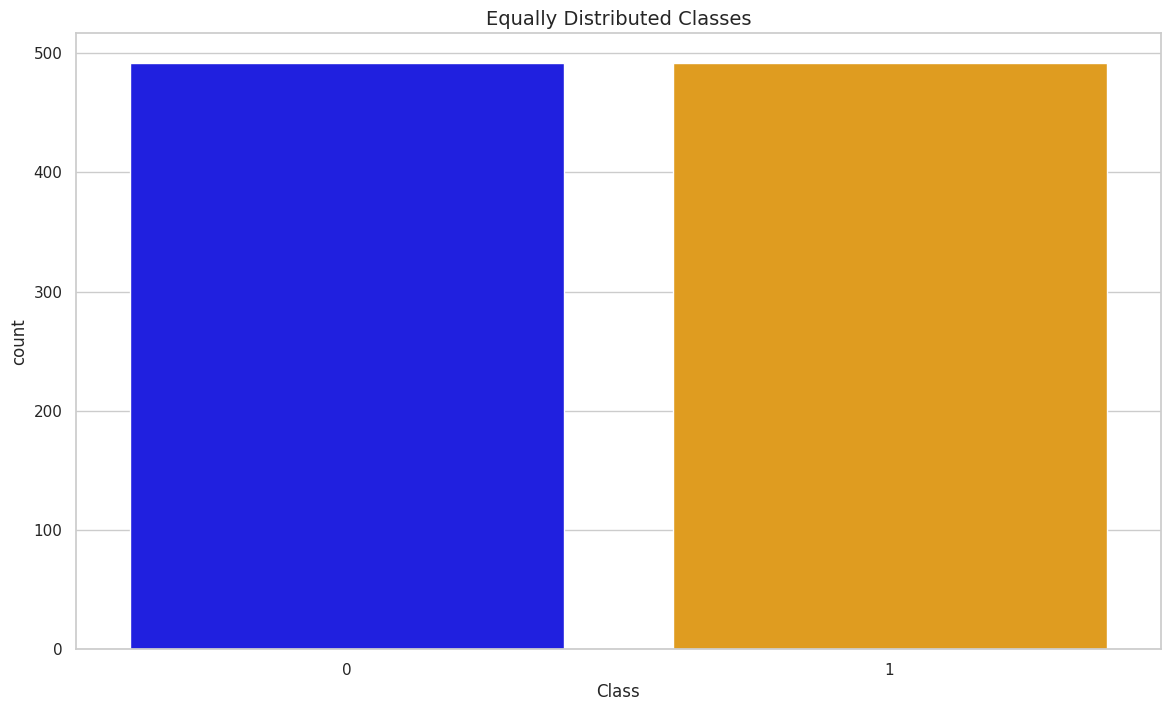

In [34]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### ***CORRELATION MATRICES***

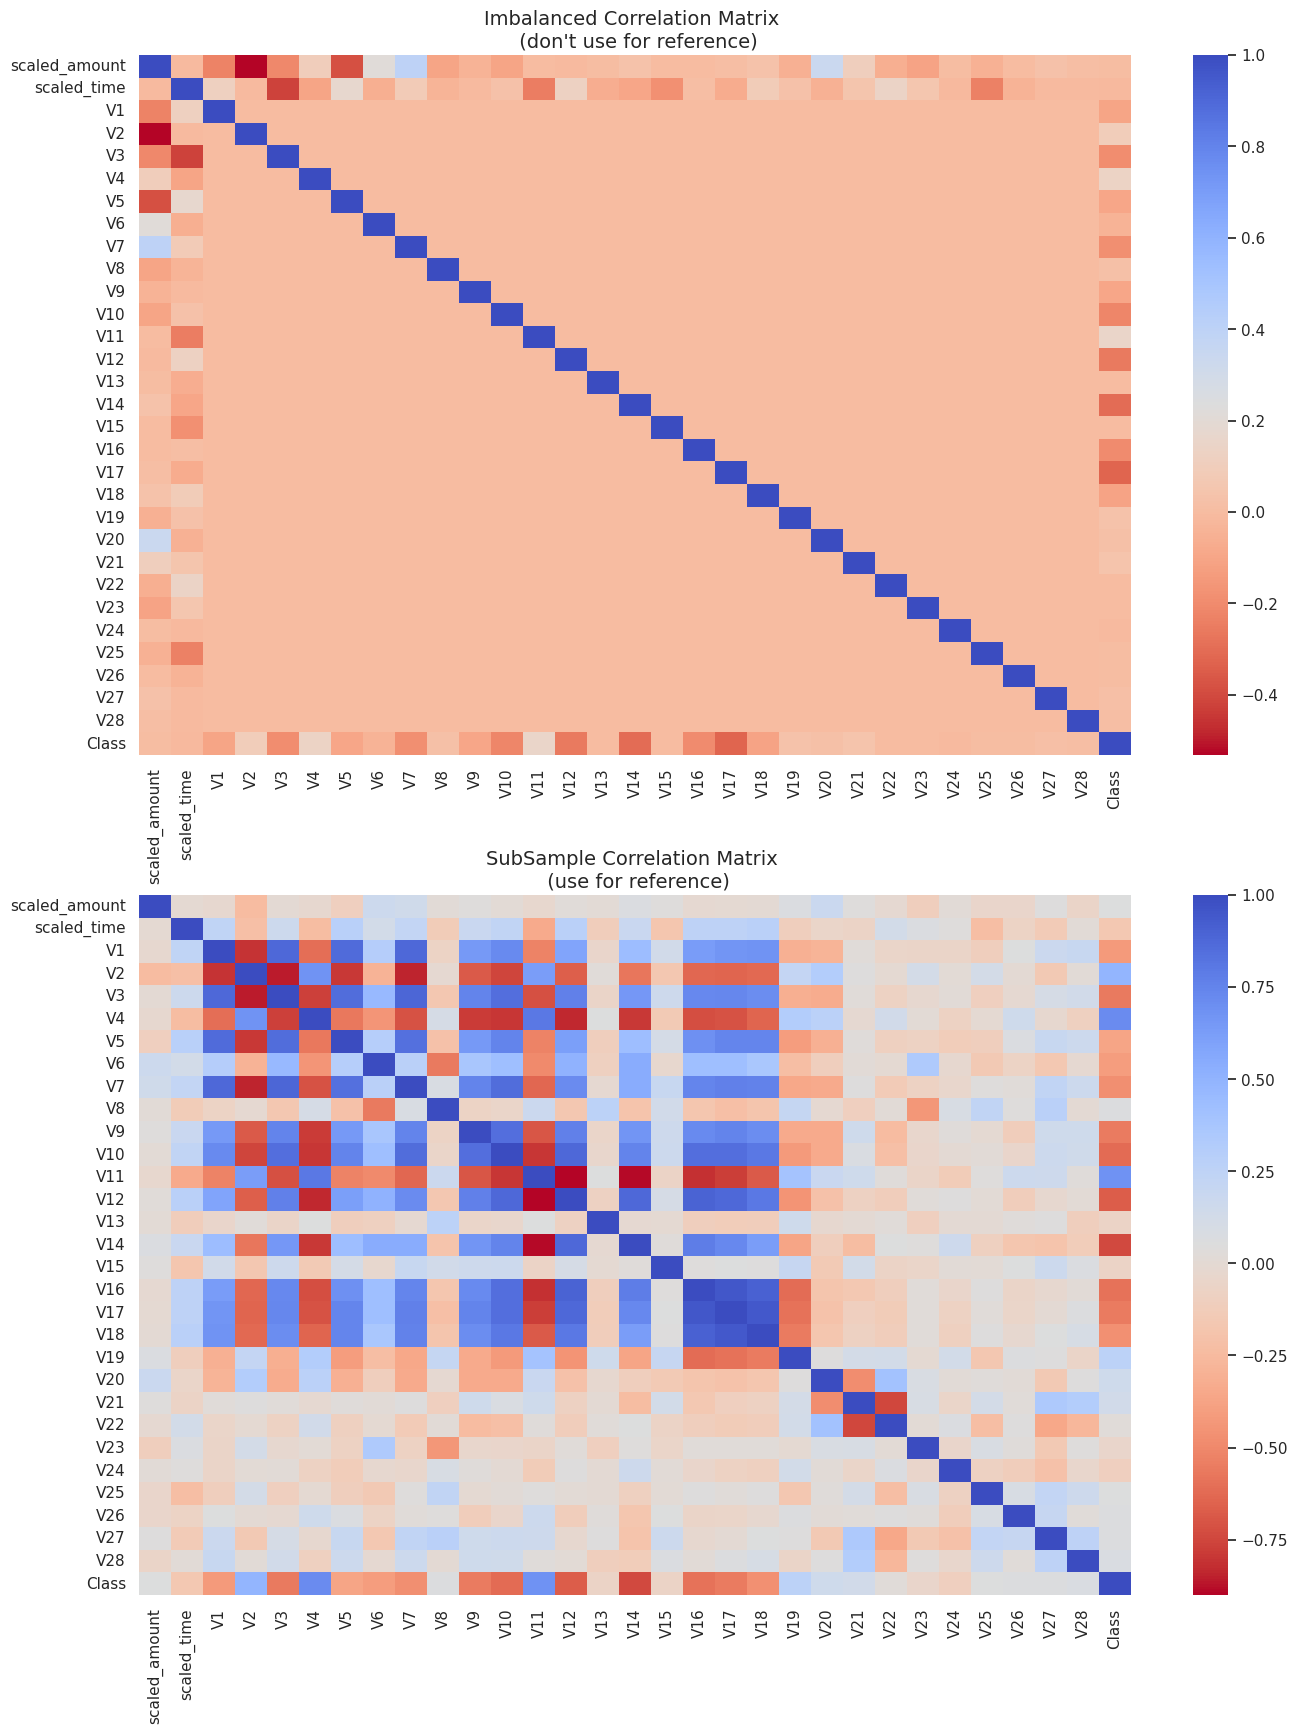

In [35]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Entire DataFrame (to show how the correlation looks like in an imbalanced dataset)
corr = df.corr() # calculate correlation between features
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr() # calculate correlation between features
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("SubSample Correlation Matrix \n (use for reference)", fontsize=14)
plt.show()

In [36]:
sol = (sub_sample_corr.where(np.triu(np.ones(sub_sample_corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

print(sol[0:9])
print(sol[-9:-1])

V16  V17    0.953878
V17  V18    0.941561
V16  V18    0.909653
V12  V16    0.901715
V3   V7     0.887340
V1   V7     0.880126
     V3     0.879531
V12  V14    0.879071
     V17    0.878865
dtype: float64
V4   V10   -0.798778
V10  V11   -0.799335
V1   V2    -0.809032
V11  V16   -0.812452
V4   V12   -0.838001
V2   V7    -0.846103
     V3    -0.862864
V11  V14   -0.891189
dtype: float64


In [37]:
print(sub_sample_corr['Class'].sort_values(ascending=False))

Class            1.000000
V4               0.712101
V11              0.686676
V2               0.490014
V19              0.264222
V20              0.148572
V21              0.137153
V28              0.072703
V27              0.064009
V8               0.061060
V26              0.058624
V25              0.054466
scaled_amount    0.053265
V22              0.027115
V23             -0.040265
V13             -0.062136
V15             -0.063864
V24             -0.104806
scaled_time     -0.163148
V5              -0.366628
V6              -0.406328
V1              -0.424305
V18             -0.467295
V7              -0.472043
V9              -0.555849
V17             -0.556295
V3              -0.564946
V16             -0.590986
V10             -0.623200
V12             -0.676332
V14             -0.742482
Name: Class, dtype: float64


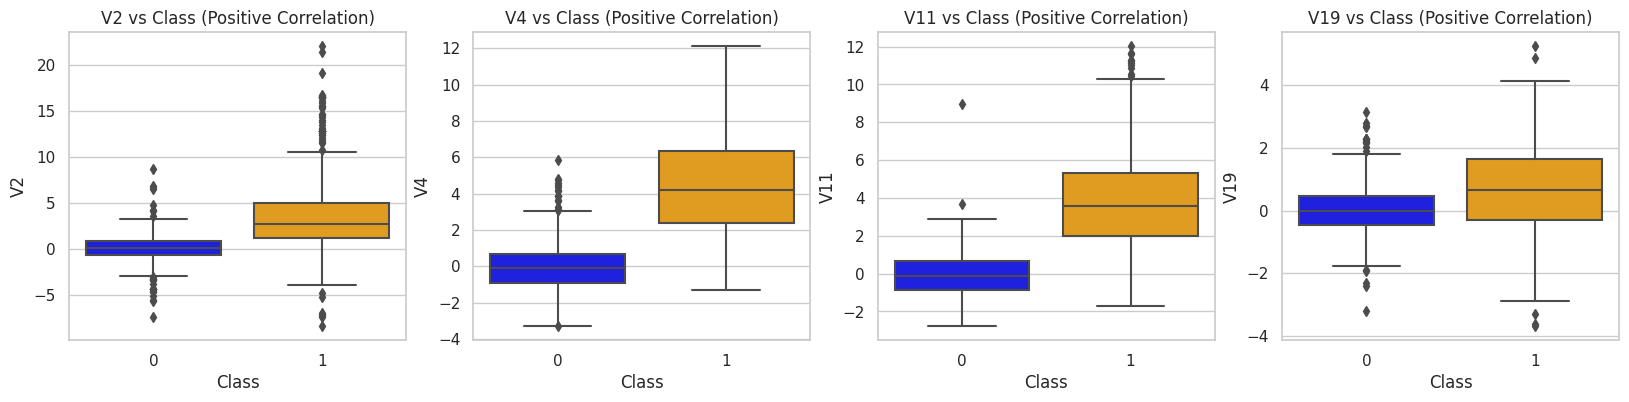

In [38]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class (Positive Correlation)')

plt.show()

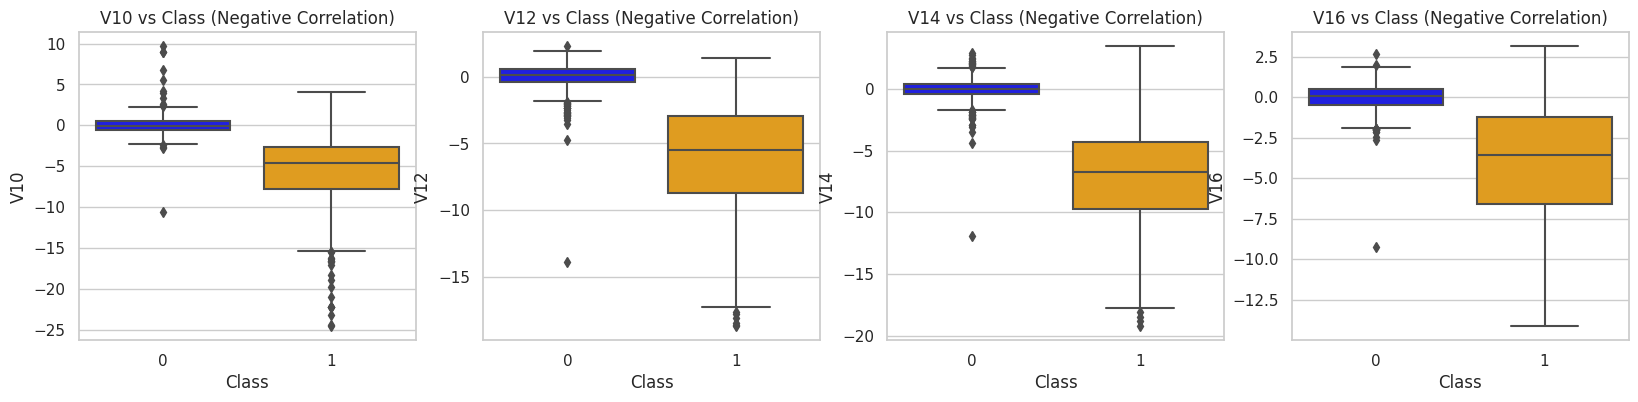

In [39]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot (negative correlation)
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class (Negative Correlation)')

plt.show()

### ***ANOMALY DETECTION***

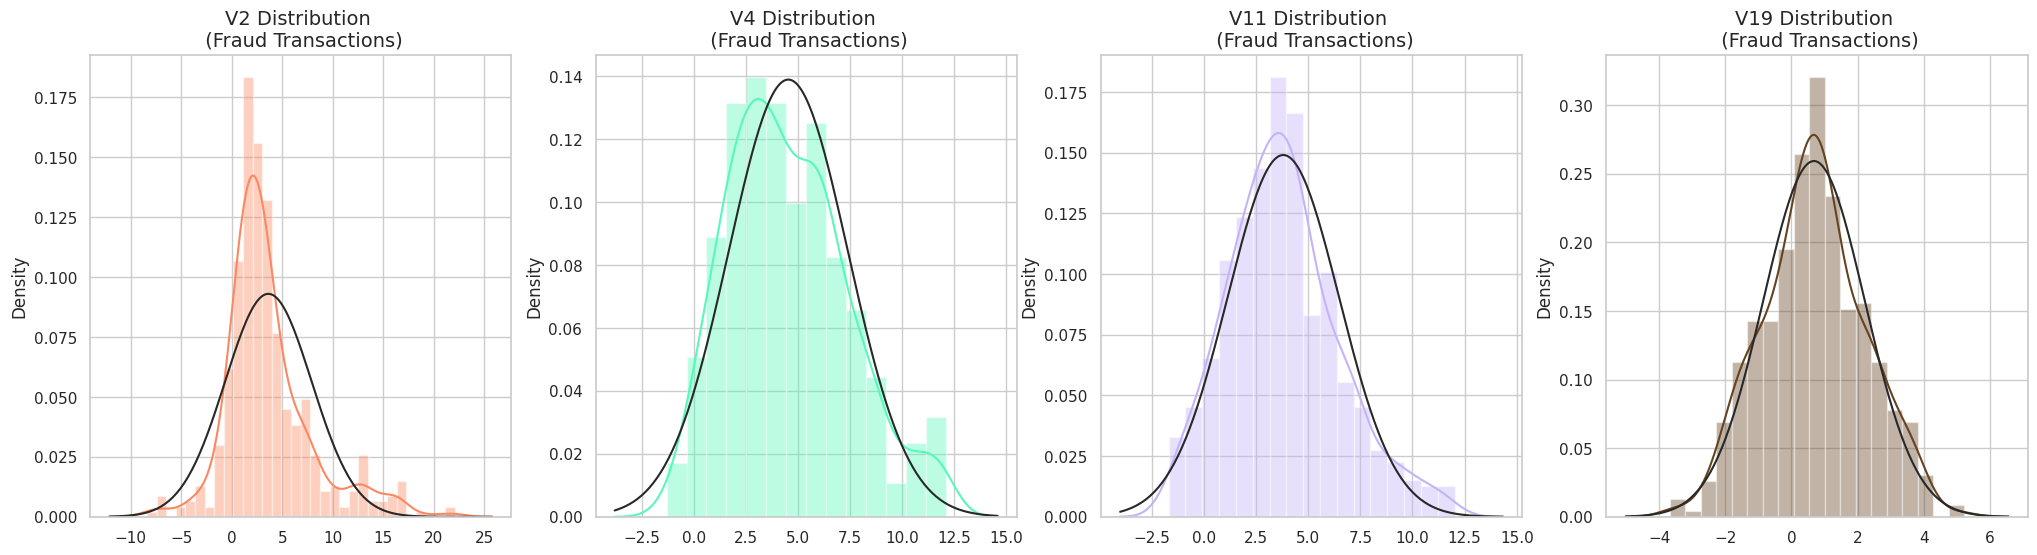

In [40]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 6))

V2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(V2_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)


v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

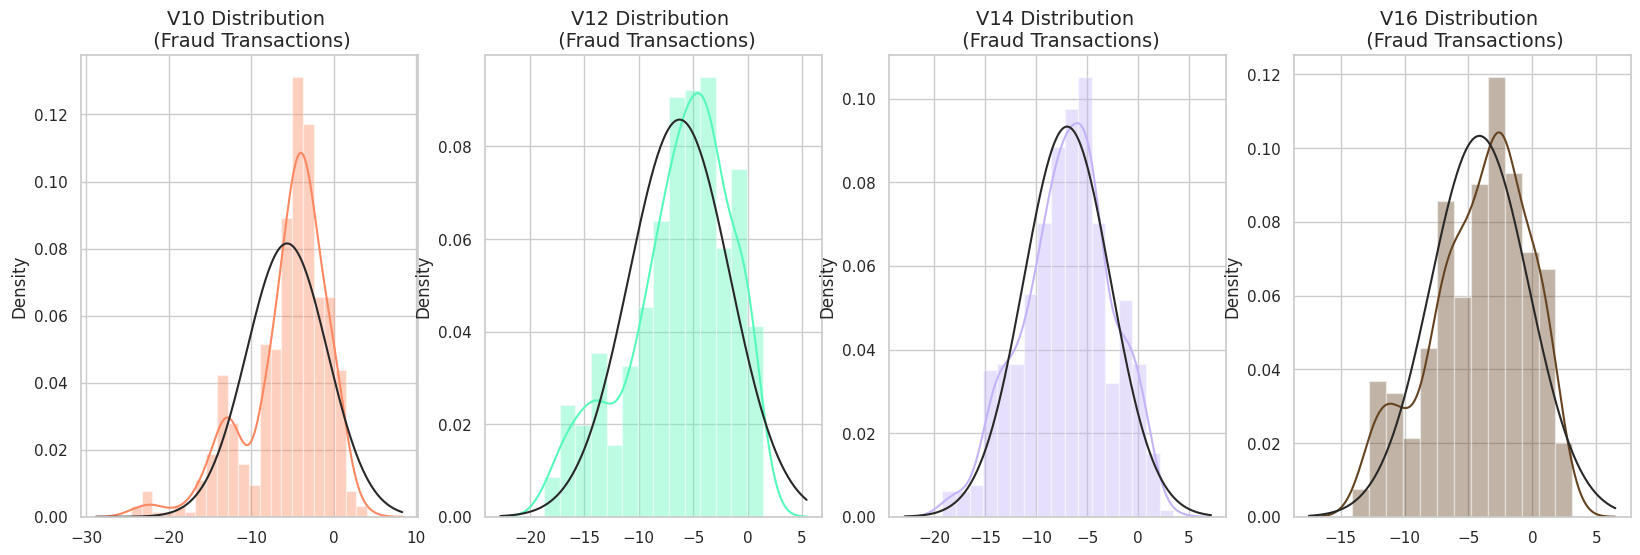

In [41]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

V10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(V10_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax4, fit=norm, color='#654321')
ax4.set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [42]:
multiplier_for_threshold = 1.5

# -----> V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * multiplier_for_threshold
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

# check in V14 to find extreme outliers; the ones who pass the threshold
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 outliers:{}'.format(outliers))
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# -----> V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * multiplier_for_threshold
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# -----> V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('iqr: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * multiplier_for_threshold
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# # -----> V4
# v4_fraud = new_df['V4'].loc[new_df['Class'] == 1].values
# q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
# print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# v4_iqr = q75 - q25
# print('iqr: {}'.format(v4_iqr))

# v4_cut_off = v4_iqr * multiplier_for_threshold
# v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
# print('Cut Off: {}'.format(v4_cut_off))
# print('V4 Lower: {}'.format(v4_lower))
# print('V4 Upper: {}'.format(v4_upper))

# outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
# print('V4 outliers:{}'.format(outliers))
# print('Feature V4 Outliers for Fraud Cases: {}'.format(len(outliers)))
# print('----' * 44)

# # -----> V2
# v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values
# q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
# print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# v2_iqr = q75 - q25
# print('iqr: {}'.format(v2_iqr))

# v2_cut_off = v2_iqr * multiplier_for_threshold
# v2_lower, v2_upper = q25 - v12_cut_off, q75 + v2_cut_off
# print('V2 Lower: {}'.format(v2_lower))
# print('V2 Upper: {}'.format(v2_upper))
# outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
# print('V2 outliers: {}'.format(outliers))
# print('Feature V2 Outliers for Fraud Cases: {}'.format(len(outliers)))
# print('----' * 44)

# # -----> V11
# v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
# q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
# print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# v11_iqr = q75 - q25
# print('iqr: {}'.format(v11_iqr))

# v11_cut_off = v11_iqr * multiplier_for_threshold
# v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
# print('Cut Off: {}'.format(v11_cut_off))
# print('V11 Lower: {}'.format(v11_lower))
# print('V11 Upper: {}'.format(v11_upper))

# # check in V14 to find extreme outliers; the ones who pass the threshold
# outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
# print('V11 outliers:{}'.format(outliers))
# print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
V14 outliers:[-18.0499976898594, -18.4937733551053, -18.8220867423816, -19.2143254902614]
Feature V14 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 980
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.6837146333443, -18.0475965708216, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
-----------------------------------------------------------------------------------------------------------------------------------------------

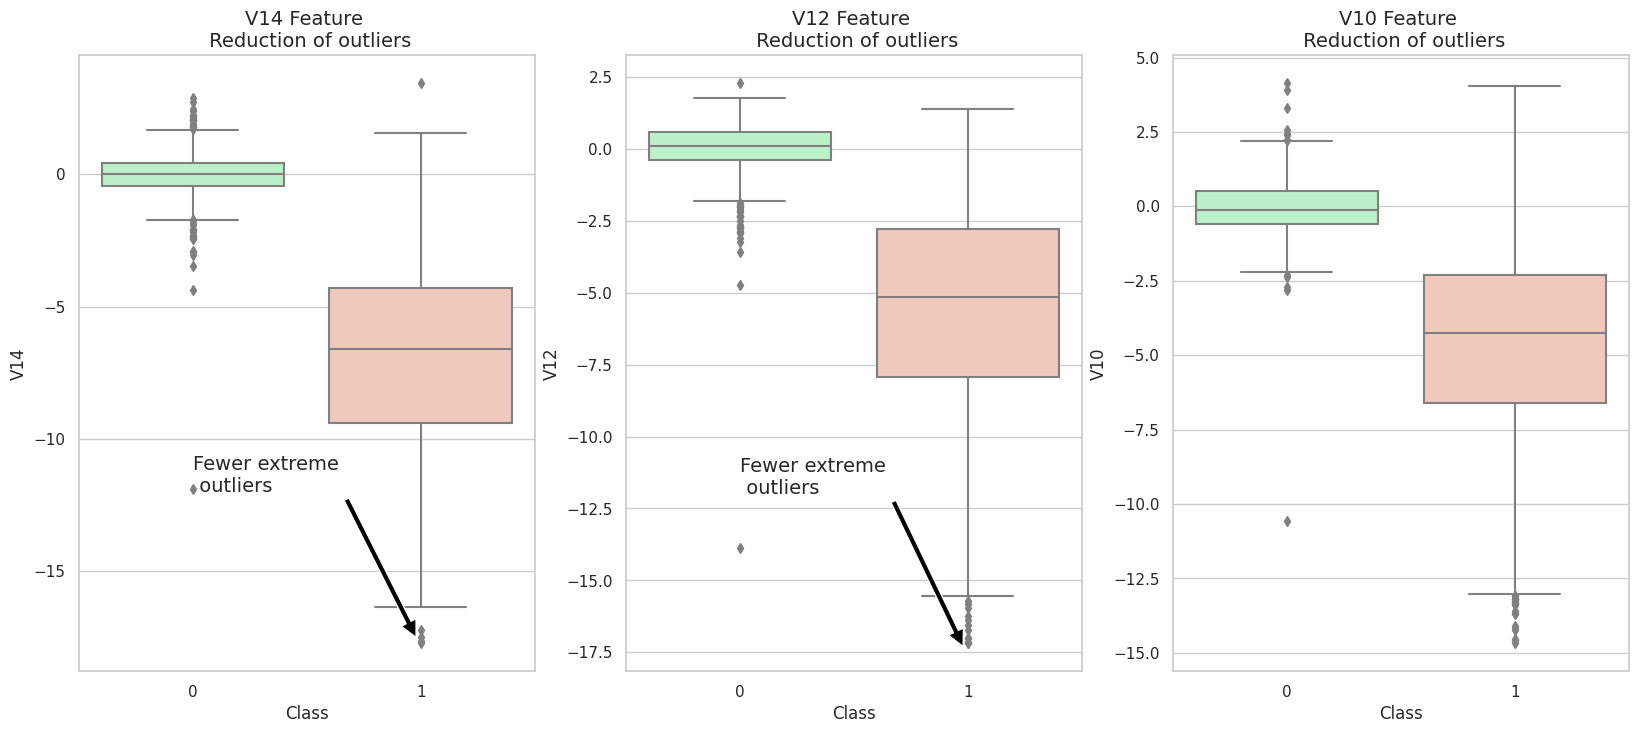

In [43]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.show()

### ***DIMENSIONALITY REDUCTION AND CLUSTERING***

We will be using three different types of dimensionality reduction techniques and pick out the best one before we move on. The three techniques are:

    t-SNE
    PCA (Principal Component Analysis)
    Truncated SVD (Singular Value Decomposition)

Understanding t-SNE:

t-SNE takes a high-dimensional dataset and reduces it to a low-dimensional graph that retains a lot of the original information.

t-SNE measures the euclidean distance between two points and then plots that distance on a normal curve that is centered on the point of interest. Lastly, it takes the distance between point 2 and where it is on the normal curve. ThE length is the "unscaled similarity". We calculate this length for all of the points.

In order to take into account the density of similar points, t-SNE will scale these lengths so that the sum of all lengths equals



In [46]:
# let's update our inputs and outputs
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('t-SNE took {:.2} s'.format(t1 - t0))

# PCA
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('PCA took {:.2} s'.format(t1 - t0))

# Truncated SVD (basically PCA but for sparse data)
t0 = time.time() # for calculating the time it takes to do t-SNE
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print('Truncated SVD took {:.2} s'.format(t1 - t0))

t-SNE took 1.4e+01 s
PCA took 0.014 s
Truncated SVD took 0.016 s


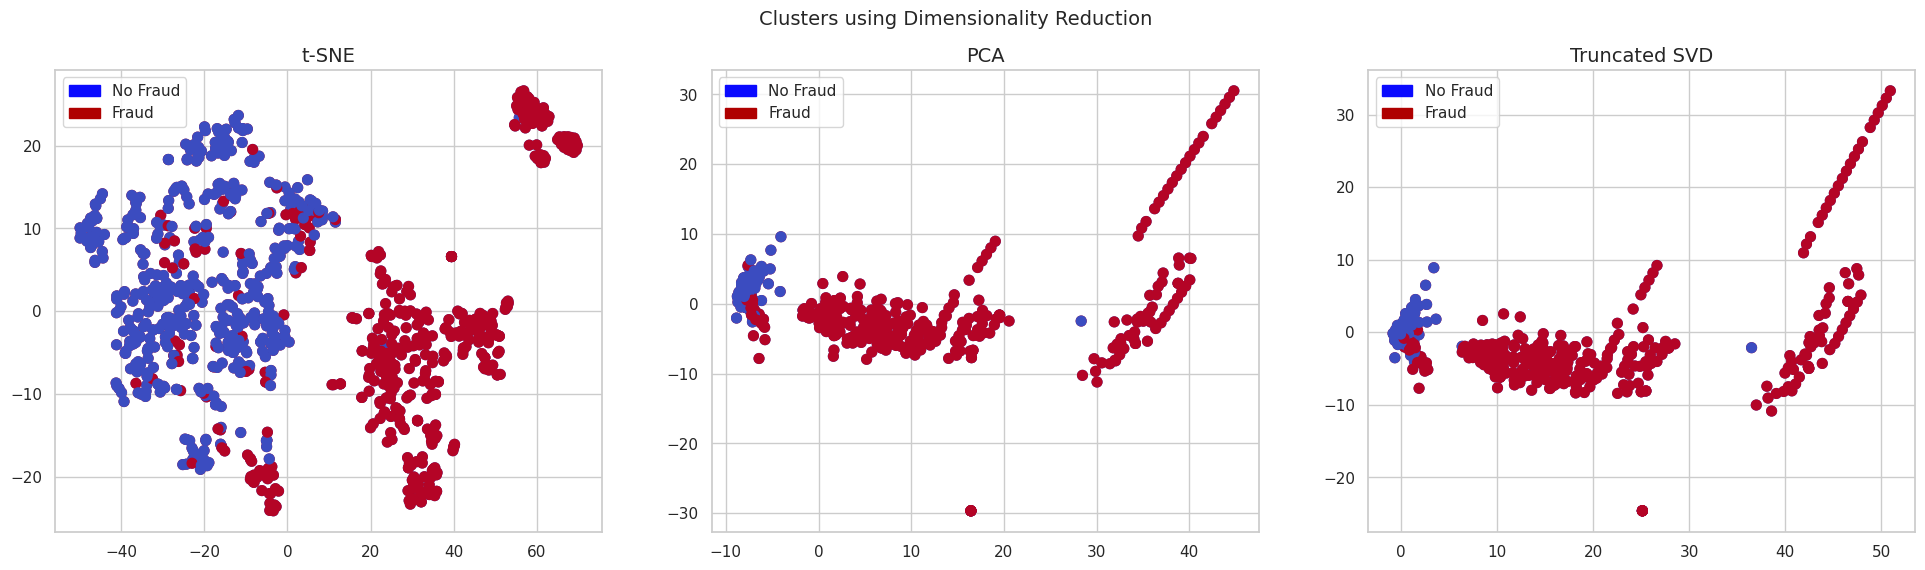

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### ***UNDERSAMPLING***

In [48]:
# let's update our inputs and outputs
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Let's split our data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn values into an array for feeding the classifications algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [49]:
from xgboost import XGBClassifier

# Use GridSearchCV to find the best paramaters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# xgboost
xgboost_params = {'objective': ["binary:logistic"]
      , 'eta': [0.01, 0.1, 0.2, 0.3]
			, 'max_depth': [3, 6, 9]
			, 'min_child_weight': [1, 10, 100, 1000]
			, 'eval_metric': ["auc"]
      }

grid_xgboost = GridSearchCV(XGBClassifier(), xgboost_params)
grid_xgboost.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
xgboost_model = grid_xgboost.best_estimator_

In [50]:
print(log_reg)
print(xgboost_model)

# LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l1',
#                    random_state=None, solver='warn', tol=0.0001, verbose=0,
#                    warm_start=False)
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, eta=0.01,
#               eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
#               max_depth=6, min_child_weight=10, missing=None, n_estimators=100,
#               n_jobs=1, nthread=None, objective='binary:logistic',
#               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#               seed=None, silent=None, subsample=1, verbosity=1)

LogisticRegression(C=0.01)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


In [51]:
from sklearn.model_selection import cross_val_score

# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ',
      round(log_reg_score.mean() * 100, 2).astype(str) + '%')

xgboost_score = cross_val_score(xgboost_model, X_train, y_train, cv=5)
print('XGBoost Cross Validation Score: ',
      round(xgboost_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.25%
XGBoost Cross Validation Score:  94.3%


***UNDERSAMPLE DURING CROSS VALIDATION***

In [52]:
from sklearn.model_selection import StratifiedKFold

In [58]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state = 42, shuffle=True)

for train_index, test_index in sss.split(undersample_X, undersample_y):
  print("Train:", train_index, "Test:", test_index)
  undersample_X_train, undersample_X_test = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
  undersample_y_train, undersample_y_test = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_X_train = undersample_X_train.values
undersample_X_test = undersample_X_test.values
undersample_y_train = undersample_y_train.values
undersample_y_test = undersample_y_test.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels; we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way

for train, test in sss.split(undersample_X_train, undersample_y_train):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_X_train[train], undersample_y_train[train])
    undersample_prediction = undersample_model.predict(undersample_X_train[test])

    undersample_accuracy.append(undersample_pipeline.score(original_X_train[test], original_y_train[test]))
    undersample_precision.append(precision_score(original_y_train[test], undersample_prediction))
    undersample_recall.append(recall_score(original_y_train[test], undersample_prediction))
    undersample_f1.append(f1_score(original_y_train[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_y_train[test], undersample_prediction))

Train: [     0      1      2 ... 284804 284805 284806] Test: [     5      7      9 ... 284778 284793 284799]
Train: [     0      3      4 ... 284804 284805 284806] Test: [     1      2     13 ... 284792 284797 284801]
Train: [     1      2      5 ... 284800 284801 284803] Test: [     0      3      4 ... 284804 284805 284806]
Train: [     0      1      2 ... 284804 284805 284806] Test: [    14     19     27 ... 284795 284796 284800]
Train: [     0      1      2 ... 284804 284805 284806] Test: [    11     15     22 ... 284791 284794 284803]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [59]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # Logistic Regression
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

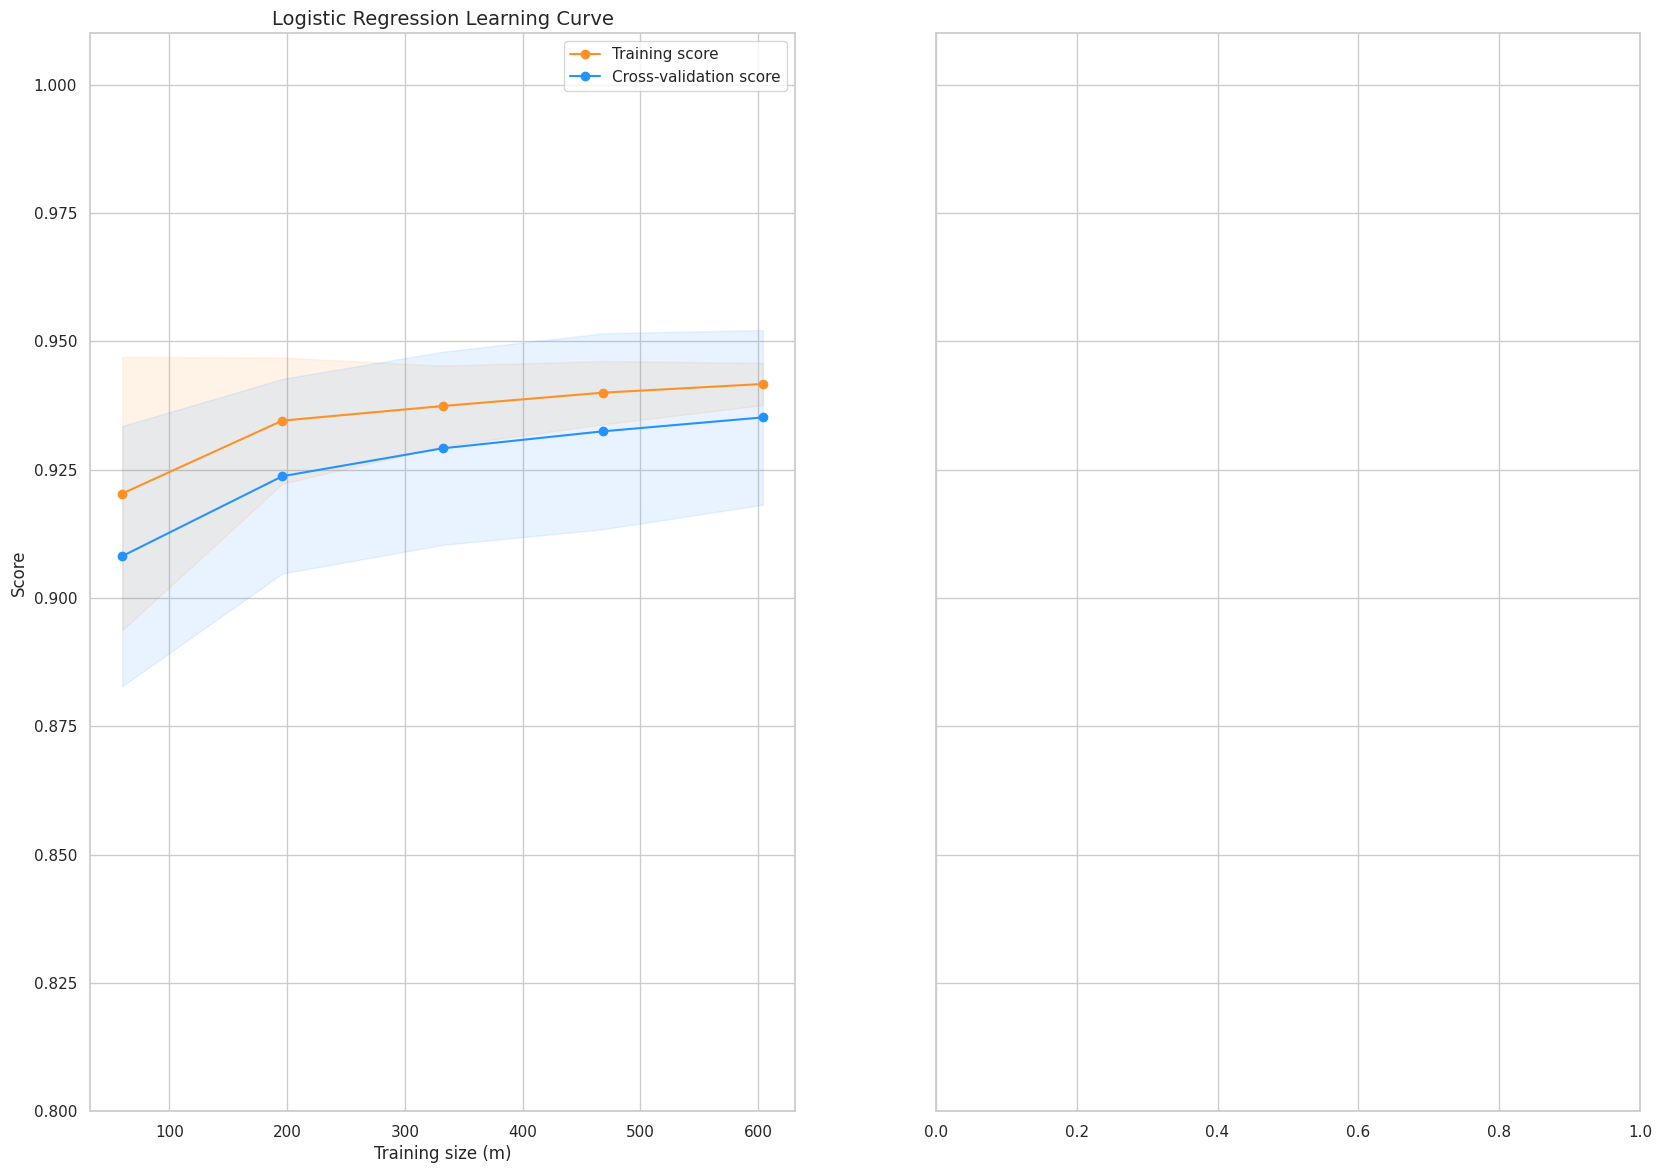

In [60]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, X_train, y_train, (0.8, 1.01), cv=cv, n_jobs=4)

In [61]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

In [62]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))

Logistic Regression:  0.9795458375463431


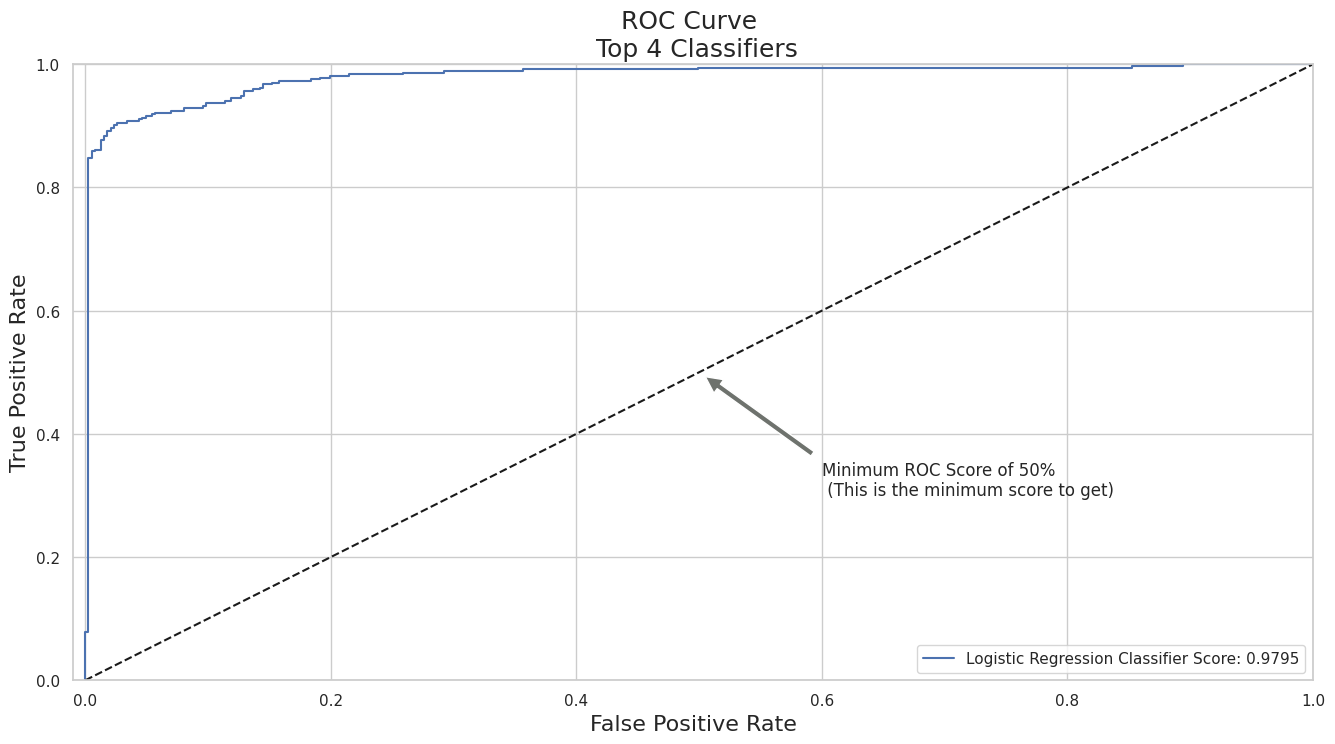

In [63]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot([0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr)
plt.show()

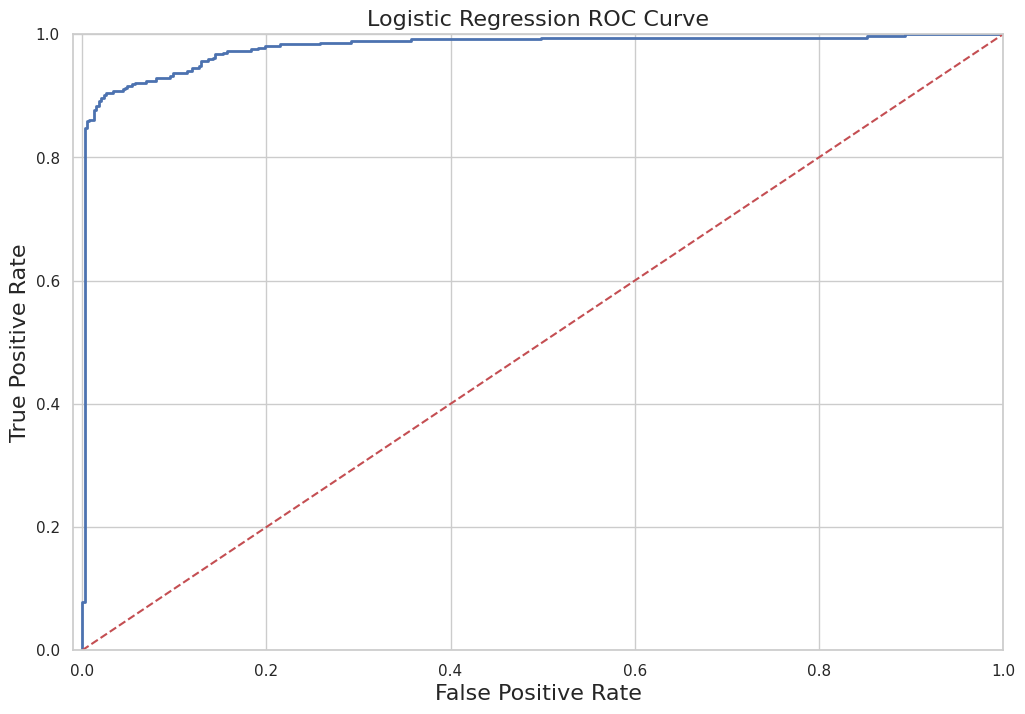

In [64]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [65]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [66]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.85
Precision Score: 0.93
F1 Score: 0.89
Accuracy Score: 0.90
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.94
Precision Score: 0.00
Recall Score: 0.07
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [67]:
undersample_y_score = log_reg.decision_function(original_X_test)

In [68]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_y_test,
                                                        undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.14


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.14')

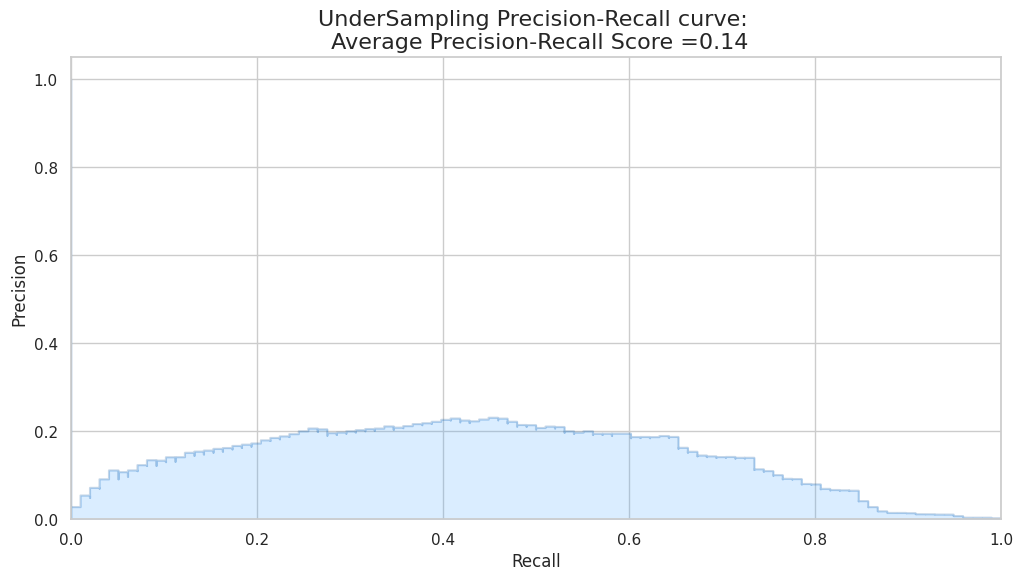

In [69]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_y_test, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

In [70]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

d = {'Technique': ['Random UnderSampling'],
     'Score': [undersample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df

#0.798942

,Technique,Score
0,Random UnderSampling,0.925926
